Input number is odd ... that is OK.

Disk filter geometry


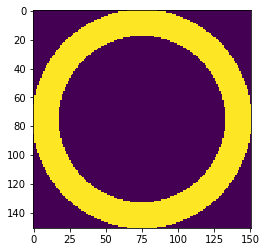

In [1]:
import numpy as np
import math as m
import cv2
from PIL import Image
import matplotlib as mlib
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float

# input data for a 'filter matrix'

# import image
#img_smpl = cv2.imread('assets/img_01.jpg', 0); N = 220
img_smpl = cv2.imread('assets/img_02.jpg', 0); N = 420
#img_smpl = cv2.imread('assets/img_03.jpg', 0); N = 590

# size of socket - diameters
# img_01.png - sice of socket - diam = 220
# img_02.png - sice of socket - diam = 420
# img_03.png - sice of socket - diam = 590

# resize the image and also the kernel 
img_smpl_res = cv2.resize(img_smpl, (720, 480))

shape1 = img_smpl_res.shape
shape2 = img_smpl.shape

ratio = shape2[0]/shape1[0]
N = N/ratio
N = int(N)

# make sure the kernel.shape is "odd"
if N%2 > 0:
    print('Input number is odd ... that is OK.\n')
else:
    print('Input number is even ... add 1 \n')
    N = N + 1
    
A = np.empty(shape=(N,N))

# coef measured from image
R_out = (N//2)*1.01
R_in = R_out*0.76 

# create the filter kernel - "Disk"
for i in range(0,N):
    for j in range(0,N):
        A[i,j]= np.sqrt((i-N//2)**2 + (j-N//2)**2)

for i in range(0,N):
    for j in range(0,N):
        if A[i,j] > R_out or A[i,j] < R_in:
            A[i,j] = 0
        else:
            A[i,j] = 1        

# converting to 8bit img
img_filtr = Image.fromarray(np.uint8(A*255) , 'L')
print('Disk filter geometry')
plt.imshow(img_filtr)

# convert img to GrayScale
img_gray = cv2.cvtColor(img_smpl_res, cv2.COLOR_GRAY2BGR)
# converting to numpy array
data = np.asarray(img_gray)
data_gray = data[:,:,0] # now only a matrix MxN - no other channels/layers

# create padding around original image of the size of Kernel to fit the filter convolution
[x_img,y_img] = data_gray.shape # size of image
[x_kern,y_kern] = A.shape # size of filter - kernel
# create matrix of zeros to be contatenated around original
Zero_side = np.zeros(shape=(x_img,y_kern//2))
Zero_line = np.zeros(shape=(x_kern//2,y_img+y_kern-1))
# putting all togather
data_center = np.concatenate((Zero_side,data_gray,Zero_side),1)
data_padding = np.concatenate((Zero_line,data_center,Zero_line),0)

#im = Image.fromarray(img_smpl_res)
#im.save("your_file.jpeg")


Convolution done...

Correlation done...



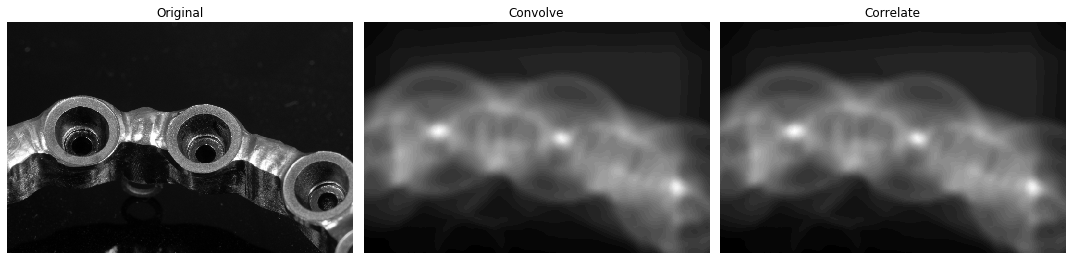

In [2]:
# convolution of padded image and Kernel filter using NDIMAGE correlate

# Convolution of image with kernel of with the shape of "disk" with diameter of the Teeth sockets (measured from original image)
# the result shows the image with maximum where the teeth socket center is located.
Kern =  A

# ...data_gray... input matrix

[x_kern,y_kern] = Kern.shape # size of filter - kernel
Kern_n_elem = x_kern*y_kern
Kern = Kern/Kern_n_elem

#from scipy.ndimage import correlate
Convolve = ndi.convolve(data_gray, Kern, mode='constant', cval=0.0)
print('Convolution done...\n')
Correlate = ndi.correlate(data_gray, Kern, mode='constant', cval=0.0)
print('Correlation done...\n')

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(data_gray, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(Convolve, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Convolve')

ax[2].imshow(Correlate, cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('Correlate')

fig.tight_layout()
#fig.savefig('Figure_all_img_02.jpg')

plt.show()


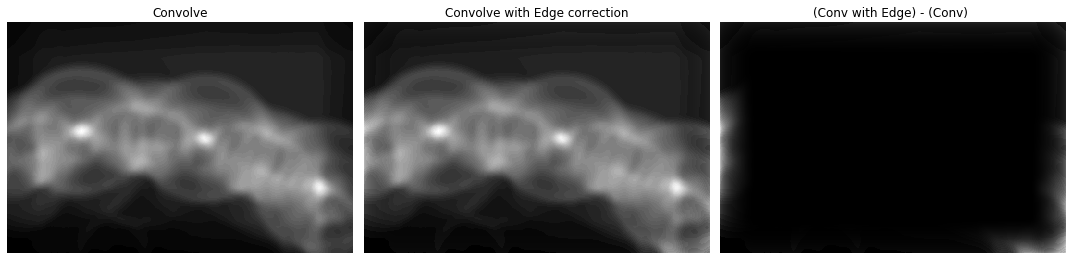

In [3]:
[x_img,y_img] = data_gray.shape # size of image
[x_padd,y_padd] = data_padding.shape # size of padded image

# creating empty matrix
Conv = np.empty(shape=(x_padd,y_padd))
Edge_x = np.ones(shape =(x_padd,y_padd)) # matrix to solve "edge and corner" problem
Edge_y = np.ones(shape =(x_padd,y_padd))

# FOR loop to create the Edge reduction matrix
for i in range(x_kern//2 , (x_kern//2)+x_img):
    #creating the "edge effect correction"    
    if i >= x_kern//2 and i<= (x_kern-1):
        x = (i-(x_kern//2)*2)/(x_kern//2)
        #print(x)
        Edge_x[i,:] = 2 - np.sqrt(1-(x)**2)            
    if i >= x_img and i <= (x_img+x_kern//2):
        x = (i-x_img)/(x_kern//2)
        Edge_x[i,:] = 2 - np.sqrt(1-x**2)
for j in range(y_kern//2 , (y_kern//2)+y_img):
    if j >= y_kern//2 and j <= (y_kern-1):
        y = (j-(y_kern//2)*2)/(y_kern//2)
        Edge_y[:,j] = 2 - np.sqrt(1-(y)**2)
    if j >= y_img and j <= (y_img+y_kern//2):
        y = (j-y_img)/(y_kern//2)
        Edge_y[:,j] = 2 - np.sqrt(1-y**2)
        
# coefitient matrix to eliminate the Edge and corner effect in Convolution (for circle filter)
# combining the Edge effect reduction matrix
Edge_comb = np.multiply(Edge_x,Edge_y) # at sides the maximum is "2", in the corner it is "4 = 2*2"
Edge_sub = Edge_comb[x_kern//2:(x_kern//2)+x_img,y_kern//2:(y_kern//2)+y_img] # submatrix in size of original image

Conv_edge = np.multiply(Convolve,Edge_sub) # edge defect lowered

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

diff = Conv_edge - Convolve

ax[0].imshow(Convolve, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Convolve')

ax[1].imshow(Conv_edge, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Convolve with Edge correction')

ax[2].imshow(diff, cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('(Conv with Edge) - (Conv) ')

fig.tight_layout()
#fig.savefig('Figure_all_img_02.jpg')

plt.show()

In the case of img_02.jpg there was after convolution a high peak at the edge of image that was amplified by the "Edge reduction". This anomaly then showed a local maximum peak where no socket was.

Figures representig the chain of steps in the process of "finding the coordinates of sockets".
Read from left to right.


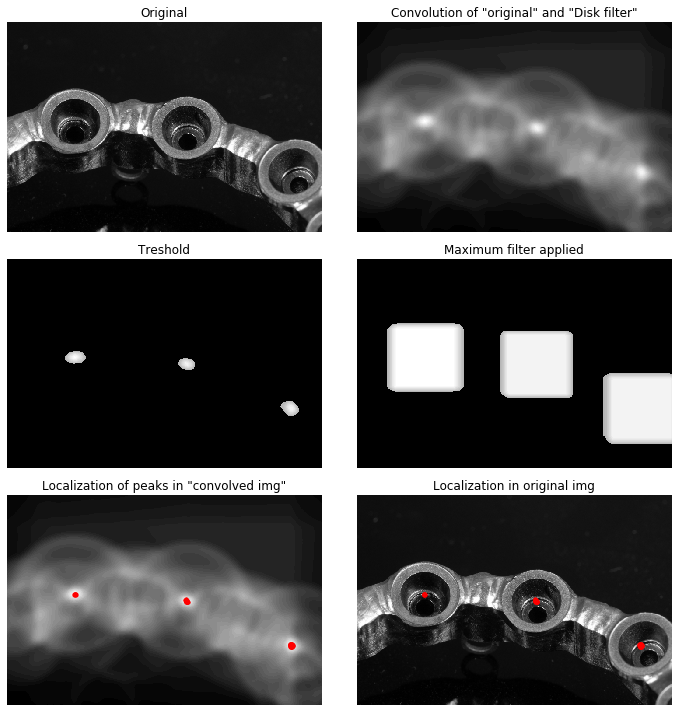

Number of local maximums = number of sockets =  87
Coordinates of the local maximum:
 [[347 651]
 [347 650]
 [347 649]
 [346 652]
 [346 651]
 [346 650]
 [346 649]
 [346 648]
 [345 653]
 [345 652]
 [345 651]
 [345 650]
 [345 649]
 [345 648]
 [344 653]
 [344 652]
 [344 651]
 [344 650]
 [344 649]
 [344 648]
 [344 647]
 [343 653]
 [343 652]
 [343 651]
 [343 650]
 [343 649]
 [343 648]
 [343 647]
 [342 653]
 [342 652]
 [342 651]
 [342 650]
 [342 649]
 [342 648]
 [342 647]
 [341 652]
 [341 651]
 [341 650]
 [341 649]
 [341 648]
 [341 647]
 [340 651]
 [340 650]
 [340 649]
 [340 648]
 [245 412]
 [245 411]
 [244 413]
 [244 412]
 [244 411]
 [244 410]
 [243 413]
 [243 412]
 [243 411]
 [243 410]
 [243 409]
 [242 412]
 [242 411]
 [242 410]
 [242 409]
 [242 408]
 [241 412]
 [241 411]
 [241 410]
 [241 409]
 [241 408]
 [240 411]
 [240 410]
 [240 409]
 [240 408]
 [240 407]
 [239 410]
 [239 409]
 [239 408]
 [239 407]
 [238 409]
 [238 408]
 [227 156]
 [227 155]
 [227 154]
 [227 153]
 [226 156]
 [226 155]
 

In [4]:
#Conv_edge_copy = Conv_edge.copy() 
Conv_edge_copy = Convolve.copy()
print('In the case of img_02.jpg there was after convolution a high peak at the edge of image that was amplified by the "Edge reduction". This anomaly then showed a local maximum peak where no socket was.\n')

# treshold background to obtain only ROI

Conv_edge_rescale = Conv_edge_copy/np.amax(Conv_edge_copy)*255 # rescale the image to 8bit values

Conv_edge_res_trsh = Conv_edge_rescale.copy() # creating a copy of a matrix
Conv_edge_res_trsh[Conv_edge_res_trsh < 180] = 0 # treshold value to omit the background and unintentional peaks that might be evaluated.

# gathering images to be used and shown
im_0 = img_as_float(img_gray) # original image
im_1 = img_as_float(Conv_edge_rescale) # convolved image
im = img_as_float(Conv_edge_res_trsh) # convolved image with treshold

# parameters in the localization of local maximum
# N ... size of original kernel used in "disc" convolution
N1 = int(N*0.85) # size of area to be summed (filter)
N2 = int(N*0.85) # minimal distance between local maximums

# image_max is the dilation of im with a N1*N1 structuring element (square)
# It is used within peak_local_max function
image_max = ndi.maximum_filter(im, size=N1, mode='constant') # mode='constant' reffers to "padding" mode

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(im, min_distance=N2, exclude_border = 0)

print('Figures representig the chain of steps in the process of "finding the coordinates of sockets".')
print('Read from left to right.')
# display results as one figure
fig, axes = plt.subplots(3, 2, figsize=(10,10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(im_0, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(im_1, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Convolution of "original" and "Disk filter"')

ax[2].imshow(im, cmap=plt.cm.gray)
ax[2].axis('off')
ax[2].set_title('Treshold')

ax[3].imshow(image_max, cmap=plt.cm.gray)
ax[3].axis('off')
ax[3].set_title('Maximum filter applied')

ax[4].imshow(im_1, cmap=plt.cm.gray)
ax[4].autoscale(False)
ax[4].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[4].axis('off')
ax[4].set_title('Localization of peaks in "convolved img"')

ax[5].imshow(img_gray, cmap=plt.cm.gray)
ax[5].autoscale(False)
ax[5].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[5].axis('off')
ax[5].set_title('Localization in original img')

fig.tight_layout()
fig.savefig('Convolve_03_Figure_all_img_02_.jpg')

plt.show()

# show coordinates of the center of the sockets
print('Number of local maximums = number of sockets = ',coordinates.shape[0])
print('Coordinates of the local maximum:\n',coordinates)